In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Packages

In [15]:
!pip install tiktoken
!pip install --upgrade cohere

!pip install langchain stability-sdk

!pip install deep-translator

In [16]:
import pandas as pd
import sys
import os
import io
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation
from deep_translator import GoogleTranslator
path = "/content/drive/Shareddrives/黑客松-阿嬤秀操作/"

img_path = "/content/drive/Shareddrives/黑客松-阿嬤秀操作2/img/"

In [17]:
%env STABILITY_HOST=grpc.stability.ai:443
%env STABILITY_KEY=<key>
# Set up our connection to the API.
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.
    verbose=True, # Print debug messages.
    engine="stable-diffusion-xl-1024-v1-0", # Set the engine to use for generation.
    # Check out the following link for a list of available engines: https://platform.stability.ai/docs/features/api-parameters#engine
)

INFO:stability_sdk.client:Opening channel to grpc.stability.ai:443
INFO:stability_sdk.client:Channel opened to grpc.stability.ai:443


env: STABILITY_HOST=grpc.stability.ai:443
env: STABILITY_KEY=sk-yTKM5xg9IBHHIliVMgoHnuMGyAHe6i6a0JBH9O742Ncy4CVQ


In [18]:
# Disable safety checker (Censorship of nudity, ..., cause very often the cersored image is completely SFW)
!pip install diffusers==0.11.1
!pip install transformers
import torch
from diffusers.pipelines.stable_diffusion import safety_checker

def sc(self, clip_input, images) :
    return images, [False for i in images]

# edit StableDiffusionSafetyChecker class so that, when called, it just returns the images and an array of True values
safety_checker.StableDiffusionSafetyChecker.forward = sc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


Before translating from Mandarin to English, you can hook up ChatGPT API to extract one important thing in a paragraph, but since it costs money and we can achieve pretty much the same with free ChatGPT 3.5 online, we do this part manually.
The next code block demonstrates what should be done in concept.

In [ ]:
# paragraph = "英國遭逢巴貝特風暴的侵襲，當地氣象單位週末前兩度發布紅色警報，各地傳出淹水災情。而巴貝特一路往丹麥和德國前進，強度在20日達到最高峰。中美洲的墨西哥則迎來三級颶風諾瑪，居民湧入超市採買，加油站則出現排隊的車流。"
# prompt_keywords = "擷取以下文章一個重點：" or "擷取以下文章一個包含動作的句子，不要總結內容："
# input = GPT(prompt_keywords+paragraph)

In [58]:
# Translation
# to_translate = '慢飛天使最棒暑假禮物　新北市圖金山石門分館提供融合玩具服務'

input="中美洲的墨西哥則迎來三級颶風諾瑪，居民湧入超市採買，加油站則出現排隊的車流"
translated = GoogleTranslator(source='auto', target='en').translate(input)
print(translated)

Mexico, in Central America, faced Category 3 Hurricane Norma. Residents flocked to supermarkets to buy goods and there were queues of traffic at gas stations.


INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got answer effff48d-8357-4b3b-ac04-972e52b6ab1d with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS'] in 19.52s


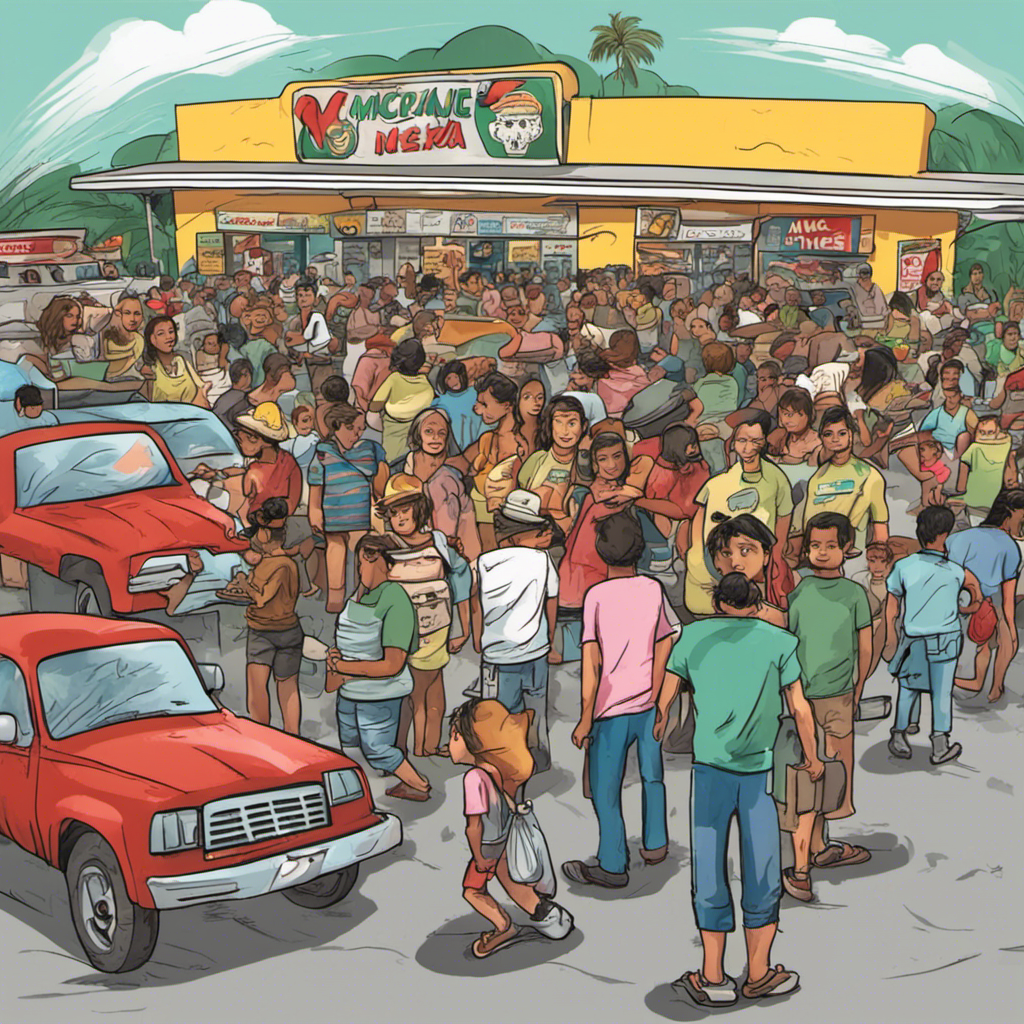

In [59]:
# seed=4253978046,
# Set up our initial generation parameters.
style = " in caricature and lively colored style"
answers = stability_api.generate(
    prompt=translated+style,
    seed=4253978046,  # If a seed is provided, the resulting generated image will be deterministic.
                     # What this means is that as long as all generation parameters remain the same, you can always recall the same image simply by generating it again.
                     # Note: This isn't quite the case for Clip Guided generations, which we'll tackle in a future example notebook.
    steps=50, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width=1024, # Generation width, defaults to 512 if not included.
    height=1024, # Generation height, defaults to 512 if not included.
    samples=1, # Number of images to generate, defaults to 1 if not included.
    sampler=generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_dpmpp_2m if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)
# Set up our warning to print to the console if the adult content classifier is tripped.
# If adult content classifier is not tripped, save generated images.
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)
            img.save(img_path+translated+".jpg")

In [67]:
input="清華大學體育館內，參賽者圍坐在電腦前，熱烈討論、合作解決問題，場面熱鬧"
translated = GoogleTranslator(source='auto', target='en').translate(input)
print(translated)

In the Tsinghua University Gymnasium, contestants sat around the computer, discussing and collaborating to solve problems. The scene was lively.


INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got answer a00ce9c7-9a9d-4048-8b9b-72394376f3be with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS'] in 20.52s


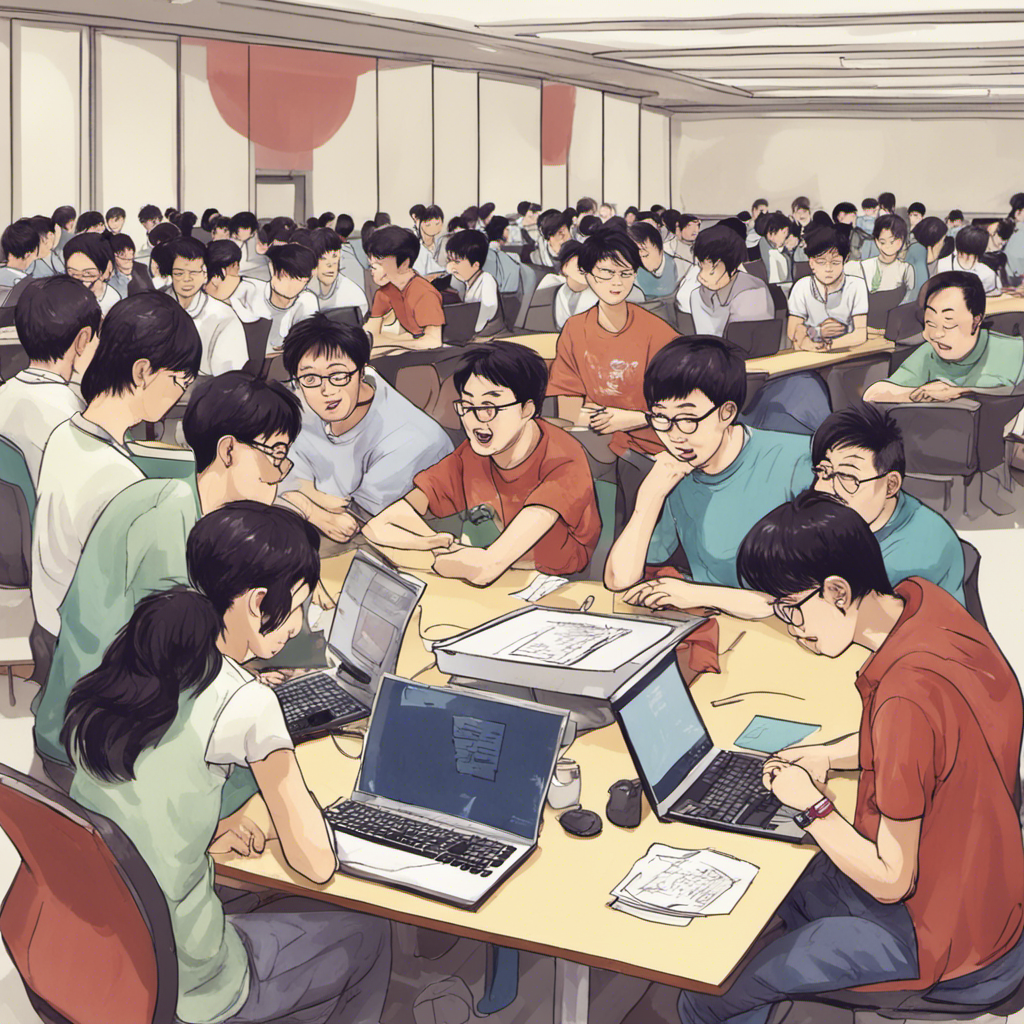

In [68]:
# seed=4253978046,
# Set up our initial generation parameters.
style = " in caricature and lively colored style"
answers = stability_api.generate(
    prompt=translated+style,
     # If a seed is provided, the resulting generated image will be deterministic.
                     # What this means is that as long as all generation parameters remain the same, you can always recall the same image simply by generating it again.
                     # Note: This isn't quite the case for Clip Guided generations, which we'll tackle in a future example notebook.
    steps=50, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width=1024, # Generation width, defaults to 512 if not included.
    height=1024, # Generation height, defaults to 512 if not included.
    samples=1, # Number of images to generate, defaults to 1 if not included.
    sampler=generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_dpmpp_2m if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)
# Set up our warning to print to the console if the adult content classifier is tripped.
# If adult content classifier is not tripped, save generated images.
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)
            img.save(img_path+translated+".jpg")